# Lake Superior Particle Tracking Demo
**Prepared for TPER Poster Session & Potluck, April 2024**

*Sandborn, D.E., Austin, J.A.*

*Large Lakes Observatory, University of Minnesota Duluth*

### Simulates paths of 64 particles released anywhere in Lake Superior April 1 - April 2 2024

### To use:
1. Enter in the coordinates you wish to release particles from.
2. Hit SHIFT+ENTER on cells 2 then 3
3. Watch the magic happen.

In [1]:
release_location = (-90.33251, 47.74420) # location of release, in decimal longitude E and latitude N
# Examples:
# Superior Entry (-91.99968, 46.71433)
# Cornucopia, WI (-91.10722, 46.86172)
# Grand Marais, MN (-90.33268, 47.74377)
# Michipicoten Island (-85.97591, 47.73003)

Running Scenario: `48 Hours of Particle Tracks'.
Imported packages.
Input scenario parameters:
helper: --------------------------------------------------------------------------
helper: Starting OceanTracker helper class
helper:   - Starting run using helper class
main: --------------------------------------------------------------------------
main:  OceanTracker version 0.4.01.006 2023-08-18 - preliminary setup
main:      Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
main:   - Searching for  hydro-files in "./fields/demo/" matching mask "lsofs.*.nc"
main:       - Found 48 files
main:       -  sorted hyrdo-model files in time order,	  0.610 sec
main:     >>> Note: output is in dir= /panfs/jay/groups/11/eminor/sandb425/OceanTracker/output/Demo_2024-04-18_17-03
main:     >>> Note: to help with debugging, parameters as given by user  are in "Demo_raw_user_params.json"
C000: -------------------------------------------------------------------

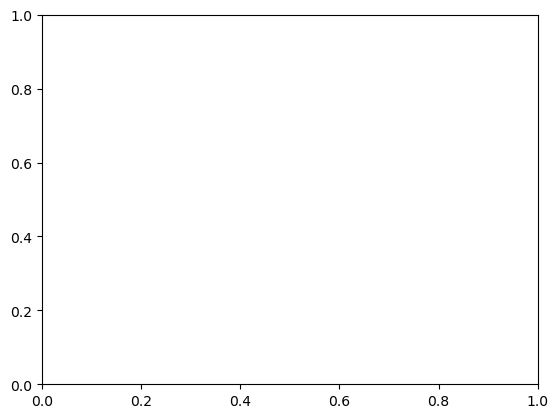

In [2]:
print("Running Scenario: `48 Hours of Particle Tracks'.")
import urllib3
import shutil
from oceantracker.main import OceanTracker
import pyproj as proj
from IPython.display import HTML # show animation in note book
import datetime
import os
from utils.mapping import plot_tracks_hourly
from oceantracker.post_processing.read_output_files import  load_output_files
#import warnings
#warnings.filterwarnings('ignore')

def toUTM16(lon, lat, destination_zone = 16):
    myproj = proj.Proj(proj = 'utm', zone = destination_zone, ellips = 'WGS84')
    return myproj(lon, lat)

print("Imported packages.")

#%% Scenario Setup
print("Input scenario parameters:")
scenario_title = 'Demo'
release_datetime = datetime.datetime(2024, 4, 1, 0, 0) # date and time to release
uncertainty_radius = 1 # radius in m of uncertainty of last position

#%% Model Run
releaase_xy = toUTM16(release_location[0], release_location[1])
release_x = releaase_xy[0]
relsease_y = releaase_xy[1]

# make instance of oceantracker to use to set parameters using code, then run
ot = OceanTracker()

# ot.settings method use to set basic settings
ot.settings(output_file_base=scenario_title, # name used as base for output files
            root_output_dir='output',             #  output is put in dir   'root_output_dir'\\'output_file_base'
            add_date_to_run_output_dir = True,
            time_step= 10* 60. # time step as seconds
            )

# ot.set_class, sets parameters for a named class
ot.add_class('reader',
             input_dir= './fields/demo/',  # folder to search for hindcast files, sub-dirs will, by default, also be searched
             file_mask=  'lsofs.*.nc',
             class_name = 'oceantracker.reader.FVCOM_reader.unstructured_FVCOM',
             cords_in_lat_long = False)  # hindcast file mask

ot.add_class('release_groups', 
             name='my_release_point', # user must provide a name for group first
                    points= [[release_x,relsease_y]        #[x,y] pairs of release locations
                             ],      # must be an N by 2 or 3 or list, convertible to a numpy array
                    release_interval= 60*60*24*365,           # seconds between releasing particles
                    pulse_size= 2**6,                   # number of particles released each release_interval
                    release_radius = uncertainty_radius, # Particles are released from random locations in circle of given radius around each point.
                    release_start_date = release_datetime.isoformat(), # Must be an ISO date as string eg. “2017-01-01T00:30:00”
                    #release_duration = 1 # Time in seconds particles are released for after they start being released, ie releases stop this time after first release.,an alternative to using “release_end_date”
            )
# run oceantracker
case_info_file_name = ot.run()

print(case_info_file_name)

print("Model run. Check output folder for results.")

#%% Graphing

# read particle track data into a dictionary using case_info_file_name
tracks = load_output_files.load_track_data(case_info_file_name)

# Set plot bounds
ax= [toUTM16(release_location[0], release_location[1])[0]-12000, #lower left x
     toUTM16(release_location[0], release_location[1])[0]+12000, #upper right x
     toUTM16(release_location[0], release_location[1])[1]-12000, #lower left y
     toUTM16(release_location[0], release_location[1])[1]+12000]  # upper right y
credit_statement = "Sandborn and Austin 2024 via OceanTracker. \nHydro model NOS/NOAA."



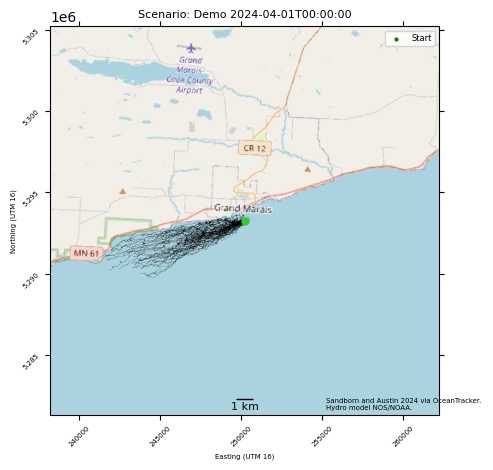

In [3]:
plot = plot_tracks_hourly(tracks,
                   show_grid = False, 
                   axis_lims = ax, 
                   credit = credit_statement, 
                   show_start = True, 
                   background_map = True,
                   #plot_file_name='./output/'+run_name+'/'+run_name+'.png',
                   figure_size = [8,8],
                   dots_per_inch = 300,
                   title = 'Scenario: '+scenario_title+' '+release_datetime.isoformat())